# Part 3: Graph Feature Enbineering & Embeddings
## Outline
1. Configure Neo4j Connection & Retrieve Baseline Data
2. Develop Theories
3. Review The Concept of Node Embedding
4. Generate and Examine Node Embeddings
5. Generate Graph Feature Dataset with Useful Node Embedding Features

In [1]:
%%capture
%pip install python-dotenv graphdatascience google-cloud-storage scikit-learn matplotlib

In [2]:
from typing import Iterable, Callable, Dict, Tuple
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience
from numpy.typing import ArrayLike
from dotenv import load_dotenv
import os
from google.cloud import storage
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Configure Neo4j Connection & Retrieve Baseline Data

In [3]:
load_dotenv('config.env', override=True)
# Use Neo4j URI and credentials according to our setup
gds = GraphDataScience(
    os.getenv('NEO4J_URI'),
    auth=(os.getenv('NEO4J_USERNAME'),
          os.getenv('NEO4J_PASSWORD')),
    aura_ds=eval(os.getenv('AURA_DS').title()))

gds.set_database("neo4j")

In [4]:
provider_feat_df = pd.read_csv('baseline.csv')
provider_feat_df

,provider,potentialFraudInd,renalDiseaseIndicatorEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,chronicCondDiabetesEnc,chronicCondIschemicHeartEnc,chronicCondOsteoporasisEnc,chronicCondrheumatoidarthritisEnc,chronicCondstrokeEnc,claimCount,providerId
0,PRV51001,0,0.054422,0.102041,0.129252,0.115646,0.034014,0.068027,0.061224,0.142857,0.156463,0.040816,0.054422,0.040816,25,51001
1,PRV51003,1,0.046105,0.089030,0.127186,0.101749,0.015898,0.065183,0.085851,0.158983,0.178060,0.052464,0.060413,0.019078,132,51003
2,PRV51004,0,0.034328,0.095522,0.131343,0.074627,0.023881,0.061194,0.094030,0.156716,0.161194,0.073134,0.068657,0.025373,149,51004
3,PRV51005,1,0.048776,0.080226,0.128060,0.095480,0.031073,0.055556,0.091337,0.150471,0.168550,0.064783,0.062335,0.023352,1165,51005
4,PRV51007,0,0.035370,0.083601,0.128617,0.070740,0.038585,0.051447,0.093248,0.157556,0.163987,0.067524,0.070740,0.038585,72,51007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.032895,0.092105,0.131579,0.098684,0.026316,0.072368,0.059211,0.131579,0.184211,0.085526,0.059211,0.026316,28,57759
5406,PRV57760,0,0.000000,0.038961,0.142857,0.025974,0.000000,0.025974,0.090909,0.233766,0.285714,0.142857,0.012987,0.000000,22,57760
5407,PRV57761,0,0.054762,0.085714,0.133333,0.095238,0.033333,0.071429,0.090476,0.130952,0.147619,0.076190,0.057143,0.023810,82,57761
5408,PRV57762,0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,1,57762


## Develop Theories
1. __Beneficiary Collusion__: Fraudulant providers may be colluding with Beneficiaries.  As such, if a provider shares beneficiaries with other fraudulant providers they are likely to be fraudulant as well.
2. __Group Code Patterns__: Fraudulant providers may use similar patterns of diagnosis group codes. These group codes dictate what a provider can charge, so naturally fraudulant providers may try to erroniously assign certain codes to collect more money. Investigating and engineering features from group codes in part 1 (without graph) would have been difficult due to the large number of unique codes a.k.a "high cardinality". This high cardinality makes EDA difficult and poses dimensionality issues for feature engineering. Graph data science can get around these challenges by leveraging specifc algorithms and embeddings that make it easy to extract higher order patterns involving high cardinality connected data.  
3. __Claim Dignosis Code Patterns__: Similar to group codes, fraudlant providers may be using certain diagnosis claim codes to justify higher reimbusement. Particularly certain codes that aren't as commonly used by other legitimate providers. There are even more unique claim codes than group codes, and this is exacerbated by the fact that each claims can have multiple. 

In a real-world scenarion we would want to use extenesive exploratory data analysis (EDA) to investigate these theories and come up with even more theories to test.  This includes analysis in notebooks like these along with using other tools like Neo4j Bloom, Browser, and Cypher.

Given time constraints for this tutorial though, we will opt for using TSNE plots of node embeddings to examine how well they distinguish between non-fraud and fraud providers.

It is important to note that while AutoML can automate the model building process, it cannot automate the processes of formatting and selecting good initial features for input.  This still requires thinking about the data and the use case, performing analysis, and examining hypotyheses.

## Review Node Embedding

The purpose of node embedding is to create numeric vectors for each node s.t. nodes that are similar in the graph will have proprtionatly similar numeric vectors. 

This is effectivly a form of dimensionality reduction that takes the complex structure of a graph and reduces it to dense vectors perfectly formatted for general purpose ML. 

<img src="https://github.com/neo4j-product-examples/graph-machine-learning-examples/blob/main/short-examples/img/embedding-vis-karate-club.png?raw=1" width="1000" align="center">

There are mmultiple different types of embeddings and going into depth is out of scope for this tutorial.  Below is a quick summary of some embeddings offered in Neo4j:

- [__FastRP__  (Fast Random Projection)](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/) - Calculates embeddings extremely fast using probabilistic sampling and linear algebra.
- [__GraphSAGE__ (Graph SAmple and aggreGatE)](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/graph-sage/) - Trains a Graph Neural Network (GNN) to generate embeddings on old and new graph data. Uses batch sampling procedures for better performance.
- [__HashGNN__](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/hashgnn/) - Quickly generates embeddings on heterogeneous graphs using a GNN like architecture but with a clever implimentation of hashing functions for speed and scalability.
- [__Node2Vec__](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/node2vec/) - Creates embeddings that represent nodes in similar neighborhoods and/or structural “roles” in the graph using adjustable random walks.

___In this tutorial we will use FastRP___ as it fast, scalable, and fairly robust. 

We can construct embeddings for each theory above by embedding over a subsets of the graph defined by the types of nodes each theory is concerned with.  i.e. 

1. __Beneficiary Collusion__: Generate embedding for Provider nodes from the `(Provider)-[HAS_CLAIMS_WITH_BENE]->(Beneficiary)` subset. 
2. __Group Code Patterns__:  Generate embedding for Provider nodes from the `(Provider)-[HAS_CLAIMS_WITH_GROUP_CODE]->(DiagnosisGroupCode)` subset. 
3. __Claim Dignosis Code Patterns__: Generate embedding for Provider nodes from the `(Provider)-[HAS_CLAIMS_WITH_CODE]->(DiagnosisCode)` subset.  

## Generate and Examine Node Embeddings

### Beneficiary Collusion

To accomplish these embeddings we are going to want to transform bipartite patterns to monopartite patterns. i.e.

`(Provider)-[HAS_CLAIMS_WITH_BENE]->(Beneficiary)` -> `(Provider)-[SHARED_BENE]->(Provider)`

There are a couple ways to do this. Either
1. Through Neo4j Graph Data Science operations
    - Cypher projection or Cypher aggregation projection
    - via collapse path operation
2. Through Cypher query

The biggest difference between these two is that the latter writes relationships to the database while the former just does transformations in memory that don't get persisted.  For production workflows 1) is ussually recommended.  However for experimentation 2) can be preferable in some cases since it allows you to further explore the new relationships with Cypher.  We will follow 2) here. 

In [5]:
# Cypher queries can take advantage of 'CALL' subqueries to reduce memeory used at once. 
gds.run_cypher(''' 
    MATCH(p1:Provider)-[r1:HAS_CLAIMS_WITH_BENE]->(b)<-[r2:HAS_CLAIMS_WITH_BENE]-(p2:Provider)
    WITH p1, p2,
    sum(r1.claimCount) + sum(r2.claimCount) AS claimCount,
    sum(r1.inscClaimReimbursedSum) + sum(r2.inscClaimReimbursedSum) AS inscClaimReimbursedSum,
    sum(r1.inpatientCount) + sum(r2.inpatientCount) AS inpatientCount
    CALL {
       WITH p1, p2, claimCount, inscClaimReimbursedSum, inpatientCount
        MERGE (p1)-[s:SHARED_BENE]->(p2)
        SET s.claimCount =claimCount, 
            s.inscClaimReimbursedSum = inscClaimReimbursedSum, 
            s.inpatientCount = inpatientCount
    } IN TRANSACTIONS OF 50_000 ROWS
''')

""


After that we can create a graph projection and run our FastRP embedding

In [6]:
if gds.graph.exists('proj').exists:
    gds.graph.get('proj').drop()
g, _ = gds.graph.project('proj', {'Provider':{'properties':['potentialFraudInd', 'providerId']}}, {'SHARED_BENE':{'orientation': 'NATURAL'}})
_

nodeProjection            {'Provider': {'label': 'Provider', 'properties...
relationshipProjection    {'SHARED_BENE': {'orientation': 'NATURAL', 'in...
graphName                                                              proj
nodeCount                                                              5410
relationshipCount                                                    336208
projectMillis                                                            65
Name: 0, dtype: object

In [7]:
# there are a ton of options for tuning these embeddings.  For now we will use mostly defaults
gds.fastRP.mutate(g, embeddingDimension=128, mutateProperty='embedding', randomSeed=7474)

nodePropertiesWritten                                                 5410
mutateMillis                                                             0
nodeCount                                                             5410
preProcessingMillis                                                      0
computeMillis                                                           40
configuration            {'nodeSelfInfluence': 0, 'propertyRatio': 0.0,...
Name: 0, dtype: object

Now we can extract the data to a dataframe

In [8]:
node_df = gds.graph.nodeProperties.stream(g,['embedding', 'potentialFraudInd', 'providerId'], separate_property_columns=True)
node_df

,nodeId,embedding,potentialFraudInd,providerId
0,0,"[-0.03552676, 0.042996697, 0.16715859, 0.17165...",0,51001
1,1,"[0.018633673, -0.14557731, -0.015833948, 0.177...",1,51003
2,2,"[0.061887413, -0.09314118, -0.011801237, 0.255...",0,51004
3,3,"[-0.04972979, 0.05870912, 0.1001744, 0.1399452...",1,51005
4,4,"[-0.058485623, 0.06720995, 0.15456235, 0.16968...",0,51007
...,...,...,...,...
5405,5405,"[0.0011870805, -0.14860895, -0.1595237, 0.0934...",0,57759
5406,5406,"[0.0028544795, -0.4028943, -0.16253513, -0.310...",0,57760
5407,5407,"[0.013254644, -0.28845257, -0.23192698, 0.2490...",0,57761
5408,5408,"[0.112650625, -0.2149107, -0.0061484724, 0.289...",0,57762


Lets try and visdualize the embeddings with TSNE.
To do this we also want to filter out embeddings that are all zeros.  This occurs with disconnected Providers - i.e. providers that don't share beneficiaries with any other providers. 

In [9]:
filtered_node_df = node_df[node_df.embedding.apply(lambda x: np.count_nonzero(x) > 0)].reset_index(drop=True)
filtered_node_df.shape

(5381, 4)

In [10]:
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=7474, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(filtered_node_df['embedding'], axis=0))

In [11]:
coord_df = pd.concat([filtered_node_df, pd.DataFrame(E, columns=['x', 'y'])], axis=1)
coord_df

,nodeId,embedding,potentialFraudInd,providerId,x,y
0,0,"[-0.03552676, 0.042996697, 0.16715859, 0.17165...",0,51001,-49.700756,0.583113
1,1,"[0.018633673, -0.14557731, -0.015833948, 0.177...",1,51003,-41.012695,-5.658977
2,2,"[0.061887413, -0.09314118, -0.011801237, 0.255...",0,51004,-39.568523,-2.856592
3,3,"[-0.04972979, 0.05870912, 0.1001744, 0.1399452...",1,51005,-45.846581,-2.987532
4,4,"[-0.058485623, 0.06720995, 0.15456235, 0.16968...",0,51007,-48.860966,-0.100442
...,...,...,...,...,...,...
5376,5405,"[0.0011870805, -0.14860895, -0.1595237, 0.0934...",0,57759,-50.465588,-54.795113
5377,5406,"[0.0028544795, -0.4028943, -0.16253513, -0.310...",0,57760,-26.577236,-71.407959
5378,5407,"[0.013254644, -0.28845257, -0.23192698, 0.2490...",0,57761,-5.452474,10.394186
5379,5408,"[0.112650625, -0.2149107, -0.0061484724, 0.289...",0,57762,32.174915,-30.180357


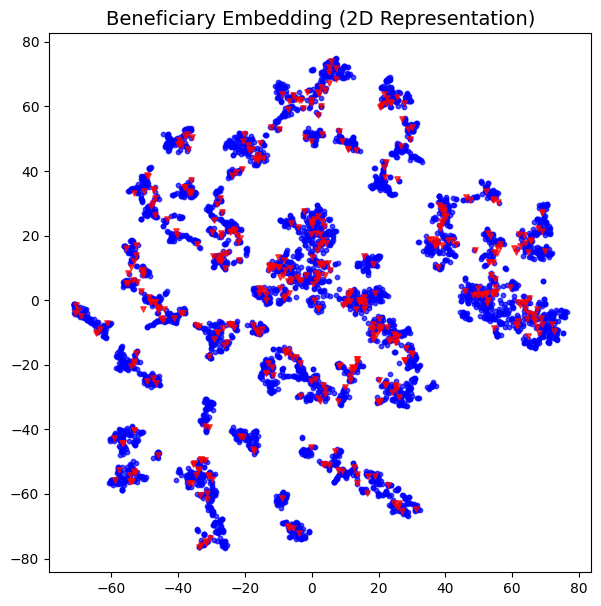

In [12]:
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Beneficiary Embedding (2D Representation)', fontsize=14)
plt.scatter(coord_df[coord_df.potentialFraudInd==0].x, 
            coord_df[coord_df.potentialFraudInd==0].y, 
            s=10, 
            marker='o', 
            c='#0000FF', 
            alpha=0.7)

plt.scatter(coord_df[coord_df.potentialFraudInd==1].x, 
            coord_df[coord_df.potentialFraudInd==1].y, 
            s=15, 
            marker='v', 
            c='#FF0000', 
            alpha=0.7)

In this situation we can tell the embeddings split off into distinct clusters. However it isn 't aligned to the fraud indicator.  In a more thorough analysis we could try filtering the `SHARED_BENE` relationships by aggregate claim counts, total reimbusrement, etc.  We could also test using such properties as relationship weights in fastRP.  However, for the intetns and purposes of this tutorial. lets not include these embeddings

In [13]:
# we can delete the SHARED_BENE relationship with the below query
gds.run_cypher(''' 
    MATCH(p1:Provider)-[s:SHARED_BENE]->(p2)
    WITH s
    CALL {
        WITH s
        DELETE s
    } IN TRANSACTIONS OF 50_000 ROWS
''')

""


### Group Code Patterns:  

Generate embedding for Provider nodes from the `(Provider)-[HAS_CLAIMS_WITH_GROUP_CODE]->(DiagnosisGroupCode)` subset. Again we will do a monopartite transformation in Cypher: `(Provider)-[HAS_CLAIMS_WITH_GROUP_CODE]->(DiagnosisGroupCode)` -> `(Provider)-[SHARED_GROUP_CODES]->(Provider)`

In [14]:
# note this may take a few minutes given the number of shared group codes
gds.run_cypher(''' 
    MATCH (p1:Provider)-[r1:HAS_CLAIMS_WITH_GROUP_CODE]->(b)<-[r2:HAS_CLAIMS_WITH_GROUP_CODE]-(p2)
    WITH p1, p2,
    sum(r1.claimCount) + sum(r2.claimCount) AS claimCount,
    sum(r1.inscClaimReimbursedSum) + sum(r2.inscClaimReimbursedSum) AS inscClaimReimbursedSum,
    sum(r1.inpatientCount) + sum(r2.inpatientCount) AS inpatientCount
    CALL {
       WITH p1, p2, claimCount, inscClaimReimbursedSum, inpatientCount
        MERGE (p1)-[s:SHARED_GROUP_CODES]->(p2)
        SET s.claimCount =claimCount, 
            s.inscClaimReimbursedSum = inscClaimReimbursedSum, 
            s.inpatientCount = inpatientCount
    } IN TRANSACTIONS OF 50_000 ROWS
''')

""


In [15]:
if gds.graph.exists('proj').exists:
    gds.graph.get('proj').drop()
g, _ = gds.graph.project('proj', {'Provider':{'properties':['potentialFraudInd', 'providerId']}}, {'SHARED_GROUP_CODES':{'orientation': 'NATURAL'}})
_

nodeProjection            {'Provider': {'label': 'Provider', 'properties...
relationshipProjection    {'SHARED_GROUP_CODES': {'orientation': 'NATURA...
graphName                                                              proj
nodeCount                                                              5410
relationshipCount                                                   1101528
projectMillis                                                           113
Name: 0, dtype: object

In [16]:
gds.fastRP.mutate(g, embeddingDimension=32, mutateProperty='embedding', randomSeed=7474)

nodePropertiesWritten                                                 5410
mutateMillis                                                             0
nodeCount                                                             5410
preProcessingMillis                                                      0
computeMillis                                                           39
configuration            {'nodeSelfInfluence': 0, 'propertyRatio': 0.0,...
Name: 0, dtype: object

In [17]:
# extract embeddings to dataframe
node_df = gds.graph.nodeProperties.stream(g, ['embedding', 'potentialFraudInd', 'providerId'], ['Provider'], separate_property_columns=True)
node_df

,nodeId,embedding,potentialFraudInd,providerId
0,0,"[0.05253912, -0.49237424, -0.03130113, -0.0435...",0,51001
1,1,"[0.05866, -0.5191457, 0.043904036, -0.04980925...",1,51003
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,51004
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,51005
4,4,"[0.07582883, -0.52022004, 0.013750045, -0.0431...",0,51007
...,...,...,...,...
5405,5405,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,57759
5406,5406,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,57760
5407,5407,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,57761
5408,5408,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,57762


In [18]:
filtered_node_df = node_df[node_df.embedding.apply(lambda x: np.count_nonzero(x) > 0)].reset_index(drop=True)
filtered_node_df.shape

(2092, 4)

In [19]:
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=7474, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(filtered_node_df['embedding'], axis=0))

In [20]:
coord_df = pd.concat([filtered_node_df, pd.DataFrame(E, columns=['x', 'y'])], axis=1)
coord_df

,nodeId,embedding,potentialFraudInd,providerId,x,y
0,0,"[0.05253912, -0.49237424, -0.03130113, -0.0435...",0,51001,-14.862587,-36.719349
1,1,"[0.05866, -0.5191457, 0.043904036, -0.04980925...",1,51003,26.313154,36.886662
2,4,"[0.07582883, -0.52022004, 0.013750045, -0.0431...",0,51007,1.815279,-13.638750
3,5,"[0.13277543, -0.49494565, -0.014426645, -0.041...",0,51008,-23.224335,-19.859264
4,6,"[0.09009166, -0.48573375, -0.036592633, -0.046...",0,51011,-35.529892,-26.175880
...,...,...,...,...,...,...
2087,5369,"[0.07627883, -0.5256411, -0.023311308, -0.0302...",0,57719,-14.655201,-3.510444
2088,5377,"[0.079001434, -0.48070806, -0.014775427, -0.01...",0,57728,-30.281664,-41.737587
2089,5378,"[0.097227305, -0.533661, -0.019364916, -0.0263...",0,57729,-12.861095,-44.310913
2090,5381,"[0.0961771, -0.5279223, -0.007775871, -0.02938...",0,57732,8.957355,-2.212829


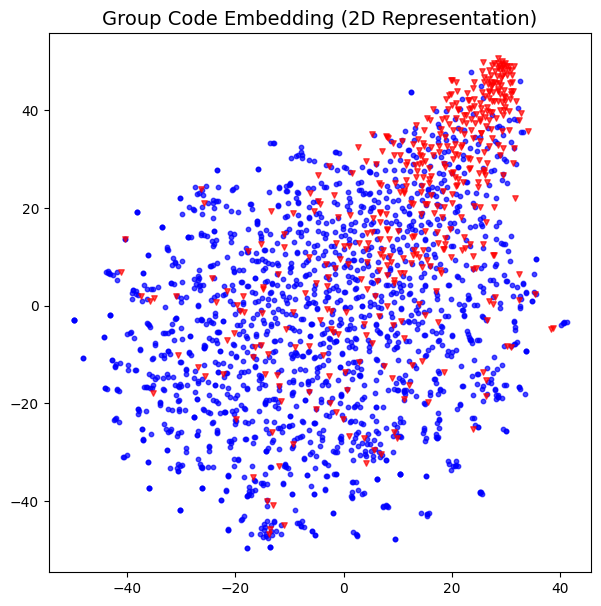

In [21]:
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Group Code Embedding (2D Representation)', fontsize=14)
plt.scatter(coord_df[coord_df.potentialFraudInd==0].x, 
            coord_df[coord_df.potentialFraudInd==0].y, 
            s=10, 
            marker='o', 
            c='#0000FF', 
            alpha=0.7)

plt.scatter(coord_df[coord_df.potentialFraudInd==1].x, 
            coord_df[coord_df.potentialFraudInd==1].y, 
            s=15, 
            marker='v', 
            c='#FF0000', 
            alpha=0.7)

This appears to be a strong pattern.  What we see is that the diagnosis group code embeddings could really help distinguish between fraud and non-fraud providers.

Similar to part 1. Lets collect these features in a dictionary then combine them and write to a file at the end of the notebook. 

In [22]:
feature_dfs = {}
feat_df = node_df.drop(columns=['nodeId', 'potentialFraudInd'])

emb_df = pd.DataFrame(node_df.embedding.tolist())
emb_df.columns = ['groupCodeEmb_' + str(i) for i in range(emb_df.shape[1])]
feature_dfs['groupCodeEmbedding'] = node_df.drop(columns=['nodeId', 'potentialFraudInd','embedding']).join(emb_df)
feature_dfs['groupCodeEmbedding']

,providerId,groupCodeEmb_0,groupCodeEmb_1,groupCodeEmb_2,groupCodeEmb_3,groupCodeEmb_4,groupCodeEmb_5,groupCodeEmb_6,groupCodeEmb_7,groupCodeEmb_8,...,groupCodeEmb_22,groupCodeEmb_23,groupCodeEmb_24,groupCodeEmb_25,groupCodeEmb_26,groupCodeEmb_27,groupCodeEmb_28,groupCodeEmb_29,groupCodeEmb_30,groupCodeEmb_31
0,51001,0.052539,-0.492374,-0.031301,-0.043545,-0.034770,0.616278,-0.265045,-0.460524,0.322422,...,0.172928,0.688214,0.019963,-0.180049,-0.327960,0.162312,0.170627,0.571517,0.822223,0.582086
1,51003,0.058660,-0.519146,0.043904,-0.049809,-0.034025,0.638151,-0.232120,-0.462699,0.327466,...,0.206117,0.669099,0.010288,-0.197143,-0.295783,0.131090,0.200166,0.562921,0.810900,0.564920
2,51004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,51007,0.075829,-0.520220,0.013750,-0.043127,-0.027075,0.636503,-0.238865,-0.509796,0.238677,...,0.207736,0.702469,0.046342,-0.187418,-0.270007,0.097604,0.131610,0.594672,0.813604,0.599554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,57759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5406,57760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5407,57761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5408,57762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Claim Diagnosis Code Patterns:  

Generate embedding for Provider nodes from the `(Provider)-[HAS_CLAIMS_WITH_CODE]->(DiagnosisCode)` subset. Again we will do a monopartite transformation in Cypher: `(Provider)-[HAS_CLAIMS_WITH_CODE]->(DiagnosisCode)` -> `(Provider)-[SHARED_DIAG_CODES]->(Provider)`.

However due to how frequently some codes are shared we will narrow down the Diagnosis codes we want to use.  Specifically we will narrow down to codes that we think will best help distinguish between fraud and non-fraud providers

To figure this out we can create a scatter plot from our univariate analysis, except this time using Cypher.

<AxesSubplot:xlabel='degree', ylabel='fraudScore'>

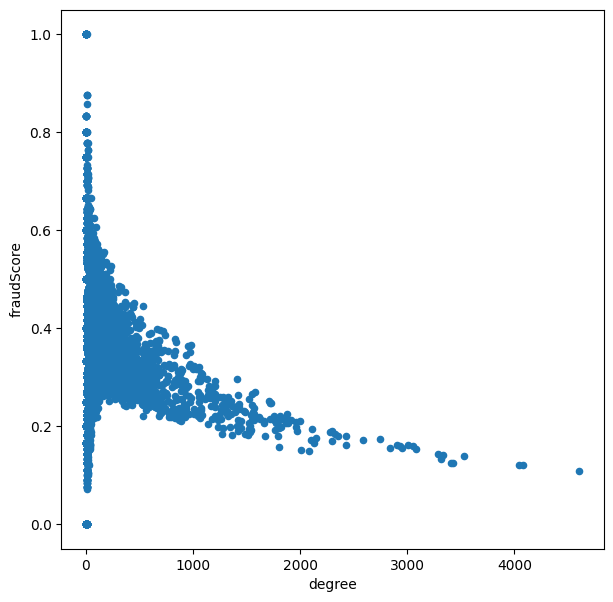

In [23]:
diag_code_df = gds.run_cypher('''
    MATCH (d:DiagnosisCode)<-[r:HAS_CLAIMS_WITH_CODE]-(p)
    WITH d.code as diagnosisCode, count(r) AS degree, sum(p.potentialFraudInd) AS fraudDegree
    RETURN diagnosisCode, degree, fraudDegree, toFloat(fraudDegree)/toFloat(degree) AS fraudScore 
    ORDER BY fraudScore DESC, degree DESC 
''')
diag_code_df.plot.scatter(x='degree', y='fraudScore')

Notice how codes used more frequently attenuate towards a fraudscore that seems close to the ratio of fraud providers in the dataset at ~9%.  

However, Diagnosis codes that are used less frequently have a much wider spread and what appears to be a higher fraud score.  As such, it make sense for us to focus on those codes used less frequently.  Filtering out the really common codes will also improve the efficiency of the monopartite transformation. 

For purposes of this tutorial lets only consider diagnosis codes with less than 50 providers using them.  

We can use Graph Data Science degree centrality to calculate how many providers use each code.  Then we can label codes with less than 50 providers which we can in turn use for our monopartite transformation. 

In [24]:
if gds.graph.exists('proj').exists:
    gds.graph.get('proj').drop()
g, _ = gds.graph.project('proj', ['Provider','DiagnosisCode'], {'HAS_CLAIMS_WITH_CODE':{'orientation':'REVERSE'}})

In [25]:
gds.degree.mutate(g, mutateProperty='providerDegree')

nodePropertiesWritten                                                 16450
centralityDistribution    {'p99': 982.0038986206055, 'min': 0.0, 'max': ...
mutateMillis                                                              0
postProcessingMillis                                                     76
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'jobId': '34e651d9-a918-4a9f-8225-ad67bcd2428...
Name: 0, dtype: object

In [26]:
gds.graph.nodeProperties.write(g, 'providerDegree', 'DiagnosisCode')

writeMillis                        48
graphName                        proj
nodeProperties       [providerDegree]
propertiesWritten               11040
Name: 0, dtype: object

In [27]:
gds.run_cypher('''
    MATCH(d:DiagnosisCode) WHERE d.providerDegree < 50
    SET d:LowUseDiagnosisCode
    RETURN count(d) AS lowUseDiagCodeCount
''')

,lowUseDiagCodeCount
0,7689


In [28]:
# this may take a few minutes
gds.run_cypher(''' 
    MATCH (p1:Provider)-[r1:HAS_CLAIMS_WITH_CODE]->(d:LowUseDiagnosisCode)<-[r2:HAS_CLAIMS_WITH_CODE]-(p2)
    WITH p1, p2,
    sum(r1.claimCount) + sum(r2.claimCount) AS claimCount,
    sum(r1.inscClaimReimbursedSum) + sum(r2.inscClaimReimbursedSum) AS inscClaimReimbursedSum,
    sum(r1.inpatientCount) + sum(r2.inpatientCount) AS inpatientCount
    CALL {
       WITH p1, p2, claimCount, inscClaimReimbursedSum, inpatientCount
        MERGE (p1)-[s:SHARED_DIAG_CODES]->(p2)
        SET s.claimCount =claimCount, 
            s.inscClaimReimbursedSum = inscClaimReimbursedSum, 
            s.inpatientCount = inpatientCount
    } IN TRANSACTIONS OF 50_000 ROWS
''')

""


Now that that is complete we can repeat the same steps as the last two embeddings.  
1. create a grpah projection
2. run FastRP embedding
3. extract features to Pandas dataframe
4. perform TSNE to see if any patterns arise

In [29]:
if gds.graph.exists('proj').exists:
    gds.graph.get('proj').drop()
g, _ = gds.graph.project('proj', {'Provider':{'properties':['potentialFraudInd', 'providerId']}}, 
                         {'SHARED_DIAG_CODES':{'orientation': 'NATURAL'}})

In [30]:
gds.fastRP.mutate(g, embeddingDimension=32, mutateProperty='embedding', randomSeed=7474)#, iterationWeights=[0.0, 1.0])

nodePropertiesWritten                                                 5410
mutateMillis                                                             0
nodeCount                                                             5410
preProcessingMillis                                                      0
computeMillis                                                           63
configuration            {'nodeSelfInfluence': 0, 'propertyRatio': 0.0,...
Name: 0, dtype: object

In [31]:
node_df = gds.graph.nodeProperties.stream(g, ['embedding', 'potentialFraudInd', 'providerId'], ['Provider'], separate_property_columns=True)
node_df

,nodeId,embedding,potentialFraudInd,providerId
0,0,"[0.13828935, -0.42056054, -0.30640584, 0.07525...",0,51001
1,1,"[0.11112509, -0.3636127, -0.29905885, 0.065841...",1,51003
2,2,"[0.107257664, -0.37848735, -0.32773125, 0.0945...",0,51004
3,3,"[0.034582138, -0.37685087, -0.28513956, 0.0418...",1,51005
4,4,"[0.10492323, -0.34776407, -0.34089047, 0.07911...",0,51007
...,...,...,...,...
5405,5405,"[0.03736476, -0.40955266, -0.3483866, 0.053882...",0,57759
5406,5406,"[0.086623594, -0.45164543, -0.39169174, 0.1173...",0,57760
5407,5407,"[0.106102586, -0.4012841, -0.31161714, 0.07008...",0,57761
5408,5408,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,57762


In [32]:
filtered_node_df = node_df[node_df.embedding.apply(lambda x: np.count_nonzero(x) > 0)].reset_index(drop=True)
filtered_node_df.shape

(4712, 4)

In [33]:
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=7474, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(filtered_node_df['embedding'], axis=0))

In [34]:
coord_df = pd.concat([filtered_node_df, pd.DataFrame(E, columns=['x', 'y'])], axis=1)
coord_df

,nodeId,embedding,potentialFraudInd,providerId,x,y
0,0,"[0.13828935, -0.42056054, -0.30640584, 0.07525...",0,51001,10.759466,-24.353518
1,1,"[0.11112509, -0.3636127, -0.29905885, 0.065841...",1,51003,-0.643705,11.930111
2,2,"[0.107257664, -0.37848735, -0.32773125, 0.0945...",0,51004,-6.877526,-10.919953
3,3,"[0.034582138, -0.37685087, -0.28513956, 0.0418...",1,51005,-32.749283,-33.380795
4,4,"[0.10492323, -0.34776407, -0.34089047, 0.07911...",0,51007,5.838312,-16.448883
...,...,...,...,...,...,...
4707,5403,"[0.07356266, -0.36332387, -0.33540326, 0.08708...",0,57757,-14.210644,-43.461681
4708,5405,"[0.03736476, -0.40955266, -0.3483866, 0.053882...",0,57759,41.793022,-3.710002
4709,5406,"[0.086623594, -0.45164543, -0.39169174, 0.1173...",0,57760,12.788070,17.083412
4710,5407,"[0.106102586, -0.4012841, -0.31161714, 0.07008...",0,57761,-6.439304,35.853470


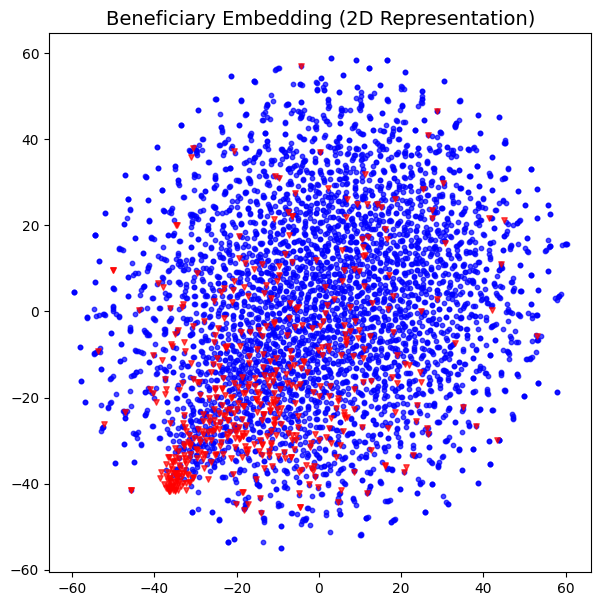

In [35]:
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Beneficiary Embedding (2D Representation)', fontsize=14)
plt.scatter(coord_df[coord_df.potentialFraudInd==0].x, 
            coord_df[coord_df.potentialFraudInd==0].y, 
            s=10, 
            marker='o', 
            c='#0000FF', 
            alpha=0.7)

plt.scatter(coord_df[coord_df.potentialFraudInd==1].x, 
            coord_df[coord_df.potentialFraudInd==1].y, 
            s=15, 
            marker='v', 
            c='#FF0000', 
            alpha=0.7)

This appears to have a pattern too.  Lets use it. 

In [36]:
emb_df = pd.DataFrame(node_df.embedding.tolist())
emb_df.columns = ['diagCodeEmb_' + str(i) for i in range(emb_df.shape[1])]
feature_dfs['diagCodeEmbedding'] = node_df.drop(columns=['nodeId', 'potentialFraudInd','embedding']).join(emb_df)
feature_dfs['diagCodeEmbedding']

,providerId,diagCodeEmb_0,diagCodeEmb_1,diagCodeEmb_2,diagCodeEmb_3,diagCodeEmb_4,diagCodeEmb_5,diagCodeEmb_6,diagCodeEmb_7,diagCodeEmb_8,...,diagCodeEmb_22,diagCodeEmb_23,diagCodeEmb_24,diagCodeEmb_25,diagCodeEmb_26,diagCodeEmb_27,diagCodeEmb_28,diagCodeEmb_29,diagCodeEmb_30,diagCodeEmb_31
0,51001,0.138289,-0.420561,-0.306406,0.075252,-0.045453,0.203819,0.116657,-0.322041,0.625014,...,0.273605,0.050406,-0.283224,0.004715,-0.448540,0.099732,0.390553,-0.028287,0.822421,0.255227
1,51003,0.111125,-0.363613,-0.299059,0.065842,-0.031720,0.231714,0.074722,-0.345757,0.573425,...,0.277371,-0.014505,-0.305225,0.026654,-0.414196,0.099659,0.446014,-0.071047,0.861041,0.252484
2,51004,0.107258,-0.378487,-0.327731,0.094516,0.017432,0.222875,0.103461,-0.338066,0.595965,...,0.261161,0.051756,-0.291583,0.019633,-0.439207,0.094085,0.433893,-0.056415,0.894695,0.303761
3,51005,0.034582,-0.376851,-0.285140,0.041898,-0.008380,0.176461,0.109299,-0.293608,0.571361,...,0.257332,0.025534,-0.295887,0.039969,-0.445222,0.089214,0.444215,-0.070490,0.875840,0.295360
4,51007,0.104923,-0.347764,-0.340890,0.079116,-0.017367,0.226403,0.105042,-0.335369,0.571484,...,0.274762,0.033359,-0.297308,0.065826,-0.414698,0.113958,0.445536,-0.033533,0.867201,0.309614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,57759,0.037365,-0.409553,-0.348387,0.053882,0.030716,0.226216,0.055731,-0.317252,0.646812,...,0.230996,-0.011263,-0.341982,0.007618,-0.343226,0.082747,0.442238,-0.086445,0.804685,0.261162
5406,57760,0.086624,-0.451645,-0.391692,0.117354,0.008928,0.237529,0.108046,-0.323686,0.581680,...,0.321729,0.002945,-0.286066,0.077699,-0.434780,0.041183,0.401512,-0.033077,0.848996,0.281134
5407,57761,0.106103,-0.401284,-0.311617,0.070089,-0.006111,0.163310,0.122236,-0.381665,0.564064,...,0.242362,0.051611,-0.336853,0.024051,-0.423022,0.096501,0.431601,-0.080111,0.875597,0.309928
5408,57762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Generate Graph Feature Dataset with Embeddings 
Now lets combine everything and write our file with graph features included

In [37]:
provider_graph_feat_df = provider_feat_df
for feature_df in feature_dfs.values():
    provider_graph_feat_df = provider_graph_feat_df.merge(feature_df, on='providerId')
provider_graph_feat_df

,provider,potentialFraudInd,renalDiseaseIndicatorEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,chronicCondDiabetesEnc,...,diagCodeEmb_22,diagCodeEmb_23,diagCodeEmb_24,diagCodeEmb_25,diagCodeEmb_26,diagCodeEmb_27,diagCodeEmb_28,diagCodeEmb_29,diagCodeEmb_30,diagCodeEmb_31
0,PRV51001,0,0.054422,0.102041,0.129252,0.115646,0.034014,0.068027,0.061224,0.142857,...,0.273605,0.050406,-0.283224,0.004715,-0.448540,0.099732,0.390553,-0.028287,0.822421,0.255227
1,PRV51003,1,0.046105,0.089030,0.127186,0.101749,0.015898,0.065183,0.085851,0.158983,...,0.277371,-0.014505,-0.305225,0.026654,-0.414196,0.099659,0.446014,-0.071047,0.861041,0.252484
2,PRV51004,0,0.034328,0.095522,0.131343,0.074627,0.023881,0.061194,0.094030,0.156716,...,0.261161,0.051756,-0.291583,0.019633,-0.439207,0.094085,0.433893,-0.056415,0.894695,0.303761
3,PRV51005,1,0.048776,0.080226,0.128060,0.095480,0.031073,0.055556,0.091337,0.150471,...,0.257332,0.025534,-0.295887,0.039969,-0.445222,0.089214,0.444215,-0.070490,0.875840,0.295360
4,PRV51007,0,0.035370,0.083601,0.128617,0.070740,0.038585,0.051447,0.093248,0.157556,...,0.274762,0.033359,-0.297308,0.065826,-0.414698,0.113958,0.445536,-0.033533,0.867201,0.309614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.032895,0.092105,0.131579,0.098684,0.026316,0.072368,0.059211,0.131579,...,0.230996,-0.011263,-0.341982,0.007618,-0.343226,0.082747,0.442238,-0.086445,0.804685,0.261162
5406,PRV57760,0,0.000000,0.038961,0.142857,0.025974,0.000000,0.025974,0.090909,0.233766,...,0.321729,0.002945,-0.286066,0.077699,-0.434780,0.041183,0.401512,-0.033077,0.848996,0.281134
5407,PRV57761,0,0.054762,0.085714,0.133333,0.095238,0.033333,0.071429,0.090476,0.130952,...,0.242362,0.051611,-0.336853,0.024051,-0.423022,0.096501,0.431601,-0.080111,0.875597,0.309928
5408,PRV57762,0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
provider_graph_feat_df.to_csv('embedding.csv', index=False)

In [39]:
load_dotenv('config.env', override=True)
REGION = os.getenv('GCLOUD_REGION')
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]

STORAGE_BUCKET = PROJECT_ID + '-fsi'
os.environ["GCLOUD_PROJECT"] = PROJECT_ID

In [40]:
client = storage.Client()
bucket = client.bucket(STORAGE_BUCKET)
if not bucket.exists():
    bucket.create(location=REGION)

In [41]:
blob = bucket.blob(os.path.join('insurance_fraud', 'embedding.csv'))
blob.upload_from_filename('embedding.csv')